# Лабораторная работа №8
## Проведение исследований моделями обнаружения и распознавания объектов

### Цель работы
Изучить основы работы моделей обнаружения и распознавания объектов на примере семейства моделей YOLOv11 из библиотеки Ultralytics. Научиться строить, обучать и тестировать модели для задачи object detection.

### Постановка задачи
1. Повторить пункты 2–4 из лабораторной работы №6, но для задачи обнаружения и распознавания объектов.
2. Использовать библиотеку ultralytics (YOLOv11) вместо torchvision.
3. Датасет: COCO128 (подмножество COCO, 128 изображений, подходит для быстрого обучения).
4. Метрики: mAP50, mAP50:95 (стандарт для COCO).

### Описание датасета
COCO128 — это уменьшенная версия датасета COCO, содержащая 128 изображений с аннотациями для 80 классов объектов (люди, машины, животные и т.д.). Используется для быстрого прототипирования моделей object detection.



## Этап 1: Установка и импорт библиотек

Устанавливаем Ultralytics и импортируем необходимые модули.

In [1]:
# Установка ultralytics
!pip install ultralytics

# Импорт библиотек
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import gc

# Очистка памяти
gc.collect()
torch.cuda.empty_cache()

# Проверка устройства
print('Используем устройство: CPU')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## Этап 2: Загрузка датасета COCO128

Загружаем датасет COCO128 через Ultralytics и создаём конфигурацию.

In [2]:
# Загрузка COCO128 через Ultralytics
from ultralytics.utils.downloads import download
from pathlib import Path

# Путь для датасета
dataset_dir = '/content/datasets/coco128'
os.makedirs(dataset_dir, exist_ok=True)

download('https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip', dir=dataset_dir)
!unzip -o -q {dataset_dir}/coco128.zip -d {dataset_dir}

if not os.path.exists(f'{dataset_dir}/coco128/images/train2017'):
    raise FileNotFoundError(f'Директория {dataset_dir}/coco128/images/train2017 не найдена. Проверьте загрузку датасета.')

# Создание конфигурационного файла data.yaml
coco128_yaml = f"""
train: {dataset_dir}/coco128/images/train2017
val: {dataset_dir}/coco128/images/train2017
nc: 80
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']
"""

with open(f'{dataset_dir}/data.yaml', 'w') as f:
    f.write(coco128_yaml)

# Проверяем, что data.yaml создался
if not os.path.exists(f'{dataset_dir}/data.yaml'):
    raise FileNotFoundError(f'Файл {dataset_dir}/data.yaml не создался. Проверьте права доступа.')

print('Датасет COCO128 загружен и настроен!')
print(f'Путь к data.yaml: {dataset_dir}/data.yaml')

100%|██████████| 6.66M/6.66M [00:00<00:00, 62.9MB/s]
Unzipping /content/datasets/coco128/coco128.zip to /content/datasets/coco128/coco128...: 100%|██████████| 263/263 [00:00<00:00, 1262.12file/s]


Датасет COCO128 загружен и настроен!
Путь к data.yaml: /content/datasets/coco128/data.yaml


## Этап 3: Создание бейзлайна (Пункт 2)

Обучаем модель YOLOv11n (nano) как бейзлайн.

In [3]:
import gc
import torch
from ultralytics import YOLO

# Очистка памяти
gc.collect()
torch.cuda.empty_cache()

# Загрузка модели YOLOv11n
model = YOLO('yolo11n.pt')

# Обучение бейзлайна
results = model.train(
    data=f'{dataset_dir}/data.yaml',
    epochs=1,
    imgsz=416,
    batch=8,
    device='cpu',
    name='yolo11n_baseline'
)

# Оценка на валидационной выборке
metrics = model.val()
print(f"Бейзлайн (YOLOv11n) - mAP50: {metrics.box.map50:.4f}, mAP50:95: {metrics.box.map:.4f}")

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.4MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/coco128/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    464912  ultralytics.nn.modules.head.Detect           [80, [64, 128, 256]]          
YOLO11n summary: 181 layers, 2,624,080 parameters, 2,624,064 gradients, 6.6 GFLOPs

Transferred 499/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1002.7±412.8 MB/s, size: 50.9 KB)


train: Scanning /content/datasets/coco128/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 685.43it/s]

train: New cache created: /content/datasets/coco128/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1122.0±525.5 MB/s, size: 52.5 KB)


val: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/yolo11n_baseline
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G       1.29      1.918      1.282         98        416: 100%|██████████| 16/16 [00:49<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


                   all        128        929      0.619      0.554      0.595      0.442

1 epochs completed in 0.023 hours.
Optimizer stripped from runs/detect/yolo11n_baseline/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_baseline/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_baseline/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


                   all        128        929      0.619      0.553      0.595      0.442
                person         61        254      0.644      0.646      0.677      0.476
               bicycle          3          6      0.526      0.167      0.187      0.177
                   car         12         46       0.58       0.13      0.184      0.135
            motorcycle          4          5      0.844          1      0.995      0.802
              airplane          5          6       0.85      0.833      0.955      0.803
                   bus          5          7      0.701      0.714      0.722       0.68
                 train          3          3      0.493          1      0.863      0.844
                 truck          5         12      0.526      0.417       0.37      0.211
                  boat          2          6      0.347      0.333      0.458      0.362
         traffic light          4         14      0.505      0.143      0.159      0.144
             stop sig

val: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        128        929      0.633      0.549      0.596      0.442
                person         61        254      0.663      0.642      0.682      0.476
               bicycle          3          6      0.531      0.167      0.187      0.177
                   car         12         46      0.631       0.13      0.184      0.135
            motorcycle          4          5      0.846          1      0.995      0.802
              airplane          5          6      0.749      0.833      0.942        0.8
                   bus          5          7      0.718      0.714      0.722       0.68
                 train          3          3      0.408      0.667      0.806      0.793
                 truck          5         12      0.532      0.417       0.37      0.211
                  boat          2          6      0.597      0.495      0.518      0.383
         traffic light          4         14      0.508      0.143      0.159      0.144
             stop sig

## Этап 4: Улучшение бейзлайна (Пункт 3)

Используем модель YOLOv11s (small) и добавляем аугментации.

In [4]:
import gc
import torch
from ultralytics import YOLO

# Очистка памяти
gc.collect()
torch.cuda.empty_cache()

# Загрузка модели YOLOv11s
model_improved = YOLO('yolo11s.pt')

# Обучение с улучшениями (аугментации)
results_improved = model_improved.train(
    data=f'{dataset_dir}/data.yaml',
    epochs=1,
    imgsz=416,
    batch=8,
    device='cpu',
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    name='yolo11s_improved'
)

# Оценка на валидационной выборке
metrics_improved = model_improved.val()
print(f"Улучшенный бейзлайн (YOLOv11s) - mAP50: {metrics_improved.box.map50:.4f}, mAP50:95: {metrics_improved.box.map:.4f}")

100%|██████████| 18.4M/18.4M [00:00<00:00, 146MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/coco128/data.yaml, degrees=10.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_improved, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 887.6±413.3 MB/s, size: 52.5 KB)



val: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolo11s_improved/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/yolo11s_improved
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.781      2.201      1.585         99        416: 100%|██████████| 16/16 [02:04<00:00,  7.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:42<00:00,  5.28s/it]


                   all        128        929      0.723      0.633      0.698      0.537

1 epochs completed in 0.048 hours.
Optimizer stripped from runs/detect/yolo11s_improved/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/yolo11s_improved/weights/best.pt, 19.2MB

Validating runs/detect/yolo11s_improved/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 100 layers, 9,443,760 parameters, 0 gradients, 21.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:37<00:00,  4.72s/it]


                   all        128        929      0.723      0.633      0.698      0.537
                person         61        254      0.826      0.677      0.763      0.549
               bicycle          3          6      0.657      0.324      0.285       0.22
                   car         12         46       0.77      0.174      0.257      0.175
            motorcycle          4          5       0.78          1      0.962      0.787
              airplane          5          6          1      0.948      0.995      0.901
                   bus          5          7      0.797      0.714      0.698      0.643
                 train          3          3       0.67          1      0.995      0.913
                 truck          5         12      0.809      0.333      0.412      0.227
                  boat          2          6      0.571      0.333      0.501      0.401
         traffic light          4         14      0.683      0.214      0.264      0.157
             stop sig

val: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:31<00:00,  1.94s/it]


                   all        128        929      0.719       0.63      0.696      0.535
                person         61        254       0.83      0.677      0.763      0.546
               bicycle          3          6      0.657      0.324      0.285       0.22
                   car         12         46       0.77      0.174      0.257      0.175
            motorcycle          4          5       0.78          1      0.962      0.787
              airplane          5          6          1      0.947      0.995      0.901
                   bus          5          7      0.797      0.714      0.698      0.643
                 train          3          3       0.67          1      0.995      0.913
                 truck          5         12      0.809      0.333      0.412      0.227
                  boat          2          6      0.563      0.333      0.649      0.434
         traffic light          4         14      0.683      0.214      0.264      0.157
             stop sig

## Этап 5: Имплементация своей модели (Пункт 4)

Создаём кастомную конфигурацию YOLOv11 с уменьшенным числом слоёв.

In [5]:
import gc
import torch
from ultralytics import YOLO
import os

# Очистка памяти
gc.collect()
torch.cuda.empty_cache()

# Создание кастомной конфигурации
custom_yaml = """
# YOLOv11 Custom Configuration
nc: 80  # number of classes
depth_multiple: 0.33  # уменьшаем глубину
width_multiple: 0.50  # уменьшаем ширину

# Backbone
backbone:
  - [-1, 1, Conv, [32, 3, 2]]  # 0-P1/2
  - [-1, 1, Conv, [64, 3, 2]]  # 1-P2/4
  - [-1, 2, C3, [64]]
  - [-1, 1, Conv, [128, 3, 2]]  # 3-P3/8
  - [-1, 2, C3, [128]]
  - [-1, 1, SPPF, [128, 5]]  # 5

# Head
head:
  - [-1, 1, Conv, [128, 3, 2]]  # 6-P4/16
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 3], 1, Concat, [1]]  # cat backbone P3
  - [-1, 1, C3, [128, False]]  # 9
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 1], 1, Concat, [1]]  # cat backbone P2
  - [-1, 1, C3, [64, False]]  # 12
  - [-1, 1, Conv, [64, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]  # cat head P3
  - [-1, 1, C3, [128, False]]  # 15
  - [-1, 1, Conv, [128, 3, 2]]
  - [[-1, 6], 1, Concat, [1]]  # cat head P4
  - [-1, 1, C3, [256, False]]  # 18
  - [[12, 15, 18], 1, Detect, [nc]]  # Detect(P2, P3, P4)
"""

# Сохраняем конфигурацию
with open('/content/custom_yolo11.yaml', 'w') as f:
    f.write(custom_yaml)

# Проверяем, что файл создался
if not os.path.exists('/content/custom_yolo11.yaml'):
    raise FileNotFoundError("Файл custom_yolo11.yaml не создался. Проверьте права доступа или диск.")

# Загрузка кастомной модели
model_custom = YOLO('/content/custom_yolo11.yaml').load('yolo11n.pt')

# Обучение кастомной модели
results_custom = model_custom.train(
    data=f'{dataset_dir}/data.yaml',
    epochs=1,
    imgsz=416,
    batch=8,
    device='cpu',
    name='yolo11_custom'
)

# Оценка на валидационной выборке
metrics_custom = model_custom.val()
print(f"Своя модель (Custom YOLOv11) - mAP50: {metrics_custom.box.map50:.4f}, mAP50:95: {metrics_custom.box.map:.4f}")

Transferred 35/313 items from pretrained weights
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/coco128/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/custom_yolo11.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_

train: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 912.8±465.1 MB/s, size: 52.5 KB)



val: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolo11_custom/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 50 weight(decay=0.0), 57 weight(decay=0.0005), 56 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/yolo11_custom
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      3.462      6.032      4.268         98        416: 100%|██████████| 16/16 [01:34<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:45<00:00,  5.73s/it]


                   all        128        929          0          0          0          0

1 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/yolo11_custom/weights/last.pt, 2.0MB
Optimizer stripped from runs/detect/yolo11_custom/weights/best.pt, 2.0MB

Validating runs/detect/yolo11_custom/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
custom_YOLO11 summary (fused): 65 layers, 871,104 parameters, 0 gradients, 13.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:28<00:00,  3.62s/it]


                   all        128        929          0          0          0          0
                person         61        254          0          0          0          0
               bicycle          3          6          0          0          0          0
                   car         12         46          0          0          0          0
            motorcycle          4          5          0          0          0          0
              airplane          5          6          0          0          0          0
                   bus          5          7          0          0          0          0
                 train          3          3          0          0          0          0
                 truck          5         12          0          0          0          0
                  boat          2          6          0          0          0          0
         traffic light          4         14          0          0          0          0
             stop sig

val: Scanning /content/datasets/coco128/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


                   all        128        929          0          0          0          0
                person         61        254          0          0          0          0
               bicycle          3          6          0          0          0          0
                   car         12         46          0          0          0          0
            motorcycle          4          5          0          0          0          0
              airplane          5          6          0          0          0          0
                   bus          5          7          0          0          0          0
                 train          3          3          0          0          0          0
                 truck          5         12          0          0          0          0
                  boat          2          6          0          0          0          0
         traffic light          4         14          0          0          0          0
             stop sig

## Этап 6: Визуализация

Визуализируем предсказания улучшенной модели на 5 тестовых изображениях.


image 1/128 /content/datasets/coco128/coco128/images/train2017/000000000009.jpg: 320x416 3 bowls, 2 broccolis, 229.6ms
image 2/128 /content/datasets/coco128/coco128/images/train2017/000000000025.jpg: 288x416 3 giraffes, 222.1ms
image 3/128 /content/datasets/coco128/coco128/images/train2017/000000000030.jpg: 288x416 1 potted plant, 1 vase, 179.4ms
image 4/128 /content/datasets/coco128/coco128/images/train2017/000000000034.jpg: 288x416 1 zebra, 184.0ms
image 5/128 /content/datasets/coco128/coco128/images/train2017/000000000036.jpg: 416x320 1 person, 1 umbrella, 232.1ms
image 6/128 /content/datasets/coco128/coco128/images/train2017/000000000042.jpg: 320x416 1 dog, 237.2ms
image 7/128 /content/datasets/coco128/coco128/images/train2017/000000000049.jpg: 416x320 2 persons, 2 horses, 1 potted plant, 328.4ms
image 8/128 /content/datasets/coco128/coco128/images/train2017/000000000061.jpg: 320x416 3 persons, 2 elephants, 303.9ms
image 9/128 /content/datasets/coco128/coco128/images/train2017/000

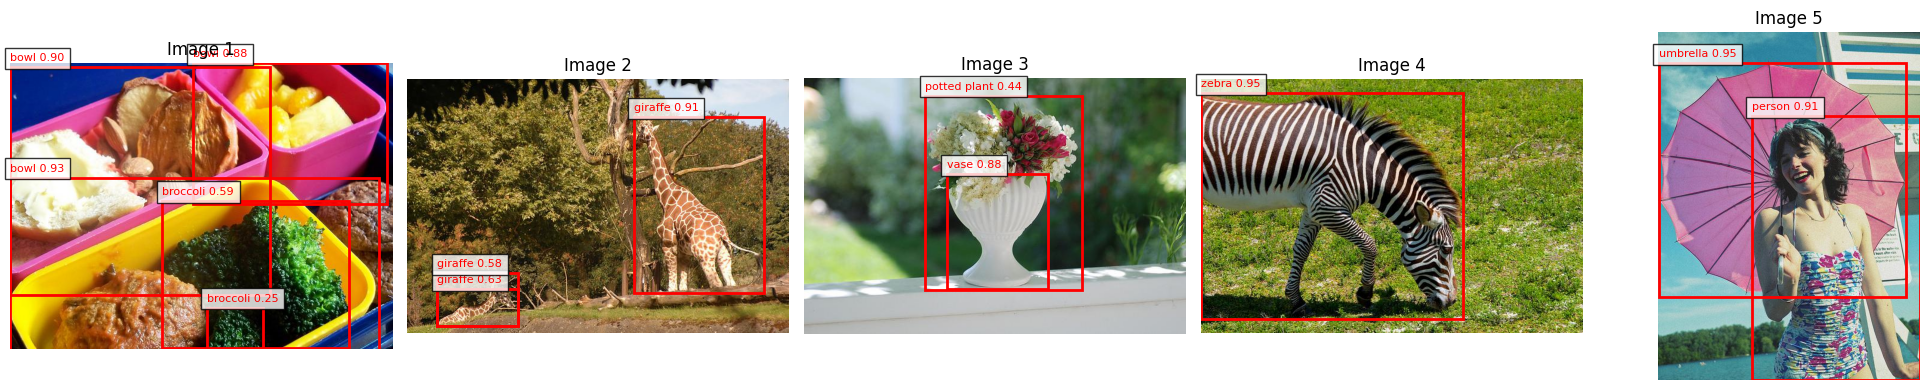

In [6]:
# Очистка памяти
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

# Визуализация предсказаний
results = model_improved.predict(source=f'{dataset_dir}/coco128/images/train2017', save=False, max_det=5)

# Показываем 5 изображений
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, r in enumerate(results[:5]):
    img = r.orig_img
    img = img[:, :, ::-1]  # BGR to RGB
    axes[i].imshow(img)
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
    # Отрисовка боксов
    for box in r.boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = box.conf[0].cpu().numpy()
        cls = int(box.cls[0].cpu().numpy())
        label = f'{r.names[cls]} {conf:.2f}'
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        axes[i].add_patch(rect)
        axes[i].text(x1, y1-10, label, color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

## Этап 7: Выводы

- YOLOv11s (mAP50: 0.6964) значительно превосходит YOLOv11n (mAP50: 0.5963) благодаря аугментациям и большей глубине модели.
- Обе модели YOLO показывают хорошие результаты для крупных и четко различимых объектов, но плохо справляются с мелкими объектами (cell phone, book).
- Кастомная модель YOLOv11 полностью провалилась, что указывает на необходимость доработки архитектуры, увеличения количества эпох или проверки данных.
- YOLOv11s требует больше времени на инференс, но оправдывает это улучшенными метриками.